# Setup

In [1]:
!pip install torchaudio datasets librosa torchlibrosa ftfy braceexpand wget webdataset --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.1 MB/s eta 0:00:00


In [2]:
#@title Mount drive & Clone GitHub
import os, shutil, getpass
from google.colab import drive

update_drive_copy = True #@param {type:"boolean"}

REPO_NAME = "Audio-ResiDual"
DRIVE_DIR_NAME = 'Progetto Deep' #@param {type:"string"}
DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_DIR_NAME + '/'
TARGET_DIR = os.path.join(DRIVE_PATH, REPO_NAME)

drive.mount('/content/drive')

GITHUB_USER = "arianna011" #@param {type: "string"}

if update_drive_copy or not os.path.exists(TARGET_DIR):
  GITHUB_URL = f"https://github.com/{GITHUB_USER}/{REPO_NAME}.git"
  TEMP_CLONE_DIR = f"/content/{REPO_NAME}"

  if os.path.exists(TEMP_CLONE_DIR):
      shutil.rmtree(TEMP_CLONE_DIR)

  print(f"Cloning {REPO_NAME} into Colab RAM...")
  exit_code = os.system(f'git clone "{GITHUB_URL}" "{TEMP_CLONE_DIR}"')

  if exit_code == 0:
      print(f"Copying to Google Drive into {TARGET_DIR}")
      if os.path.exists(TARGET_DIR):
          shutil.rmtree(TARGET_DIR)
      shutil.copytree(TEMP_CLONE_DIR, TARGET_DIR)
      print("Done")
  else:
      print("Clone failed")

CLAP_path = os.path.join(TARGET_DIR, "CLAP")
ResiDual_path = os.path.join(TARGET_DIR, "ResiDual")
%cd "{TARGET_DIR}"
!ls

Mounted at /content/drive
Cloning Audio-ResiDual into Colab RAM...
Copying to Google Drive into /content/drive/MyDrive/Progetto Deep/Audio-ResiDual
Done
/content/drive/MyDrive/Progetto Deep/Audio-ResiDual
CLAP  data_processing  README.md  ResiDual  src


In [15]:
#@title Imports
import torch
import os
from tqdm import tqdm
import pandas as pd
import librosa
import IPython.display as ipd
import math, random
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset, random_split
import data_processing
from data_processing import AudioDataset, get_dataframe, DATASETS, get_fold_dataloaders
from CLAP.src.laion_clap import htsat, model, CLAP_Module
from CLAP.src import get_audio_features
from src import analyze_attention as A

# CLAP architecture

**CLAP** (Contrastive Language-Audio Pretraining) allows to compute latent representations of both audio and text, enabling the implementation of downstream tasks like zero-shot audio classification.

Its architecture consists of a text branch and an audio branch, on which this project focuses on. In particular, in the default CLAP setting, the **HTSAT audio encoder** is considered. Its structure is presented in the picture below.

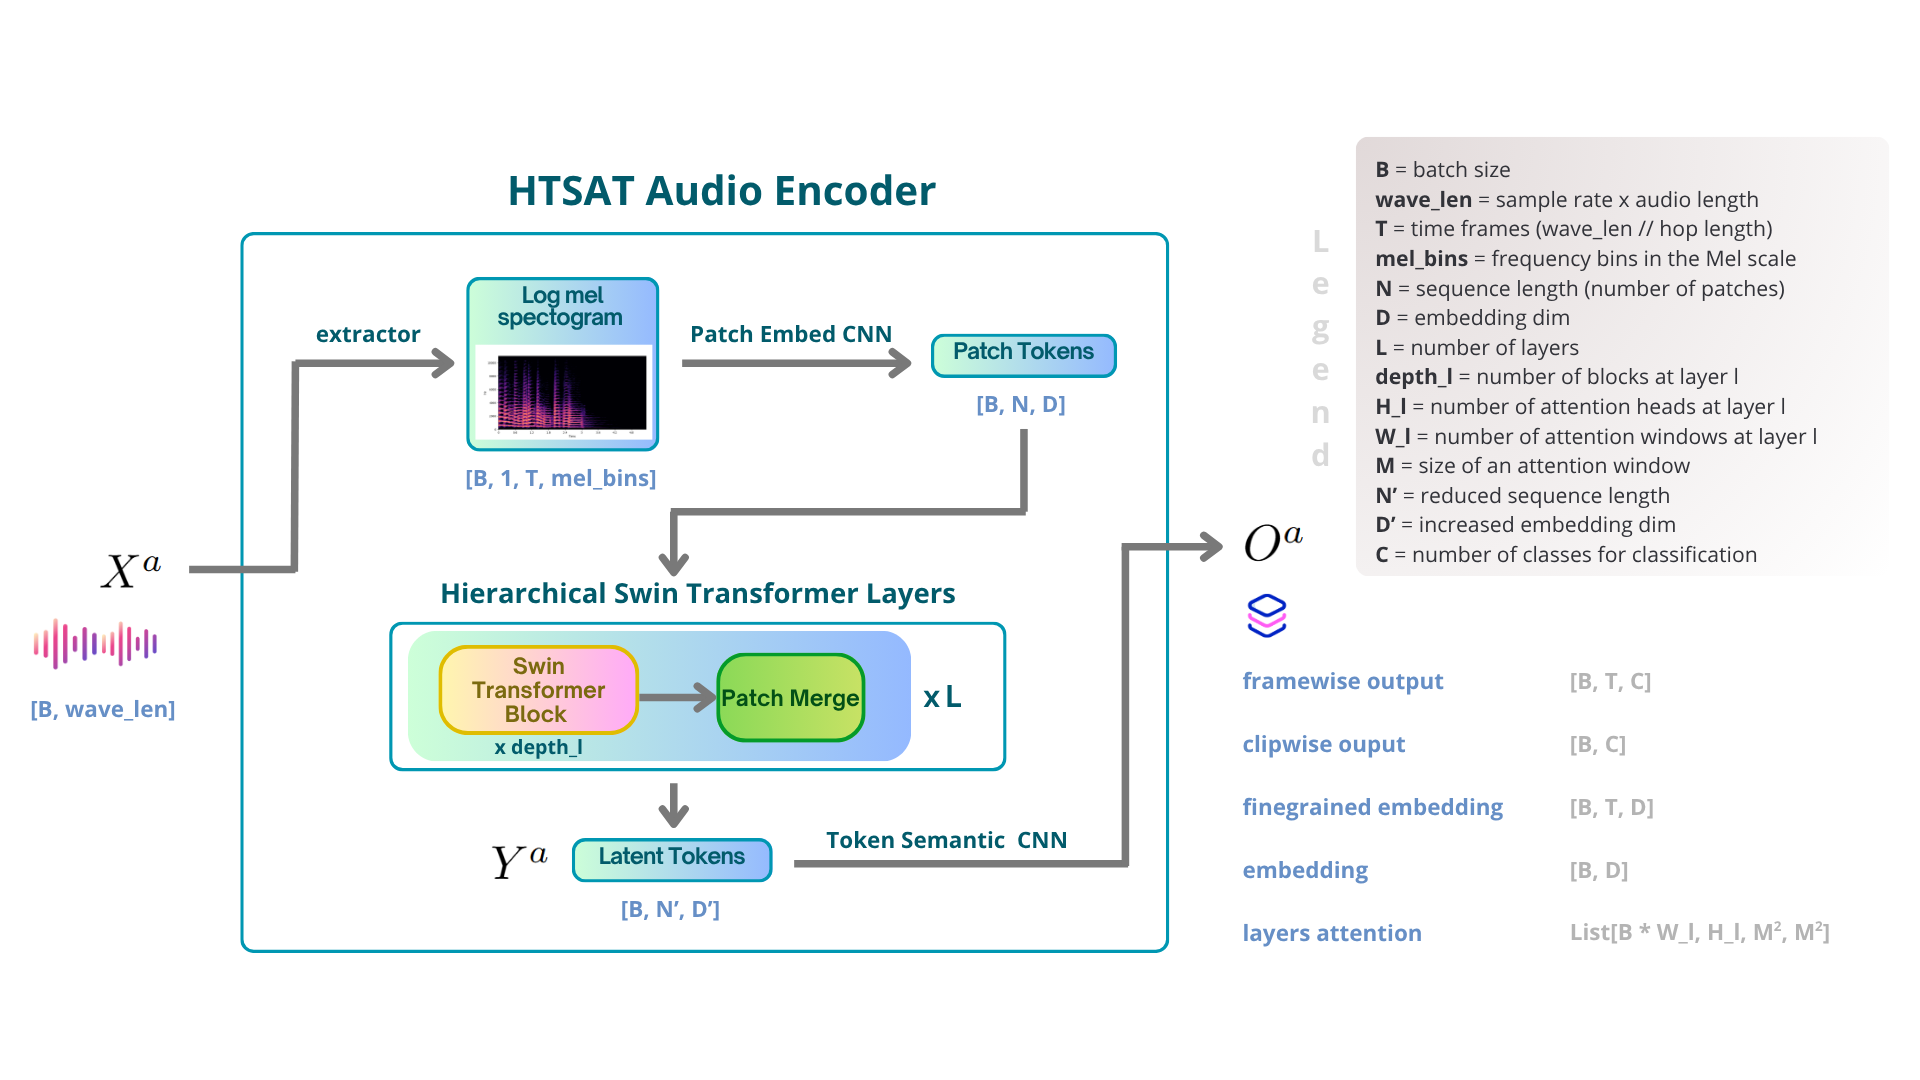

In each Swin Transformer Block, a windowed attention mechanism is used to optimize GPU computation by considering attention in local windows that will be progressively merged together across the hierarchical transformer layers, which reduce the input dimensionality and increase the number of embedding dimensions.

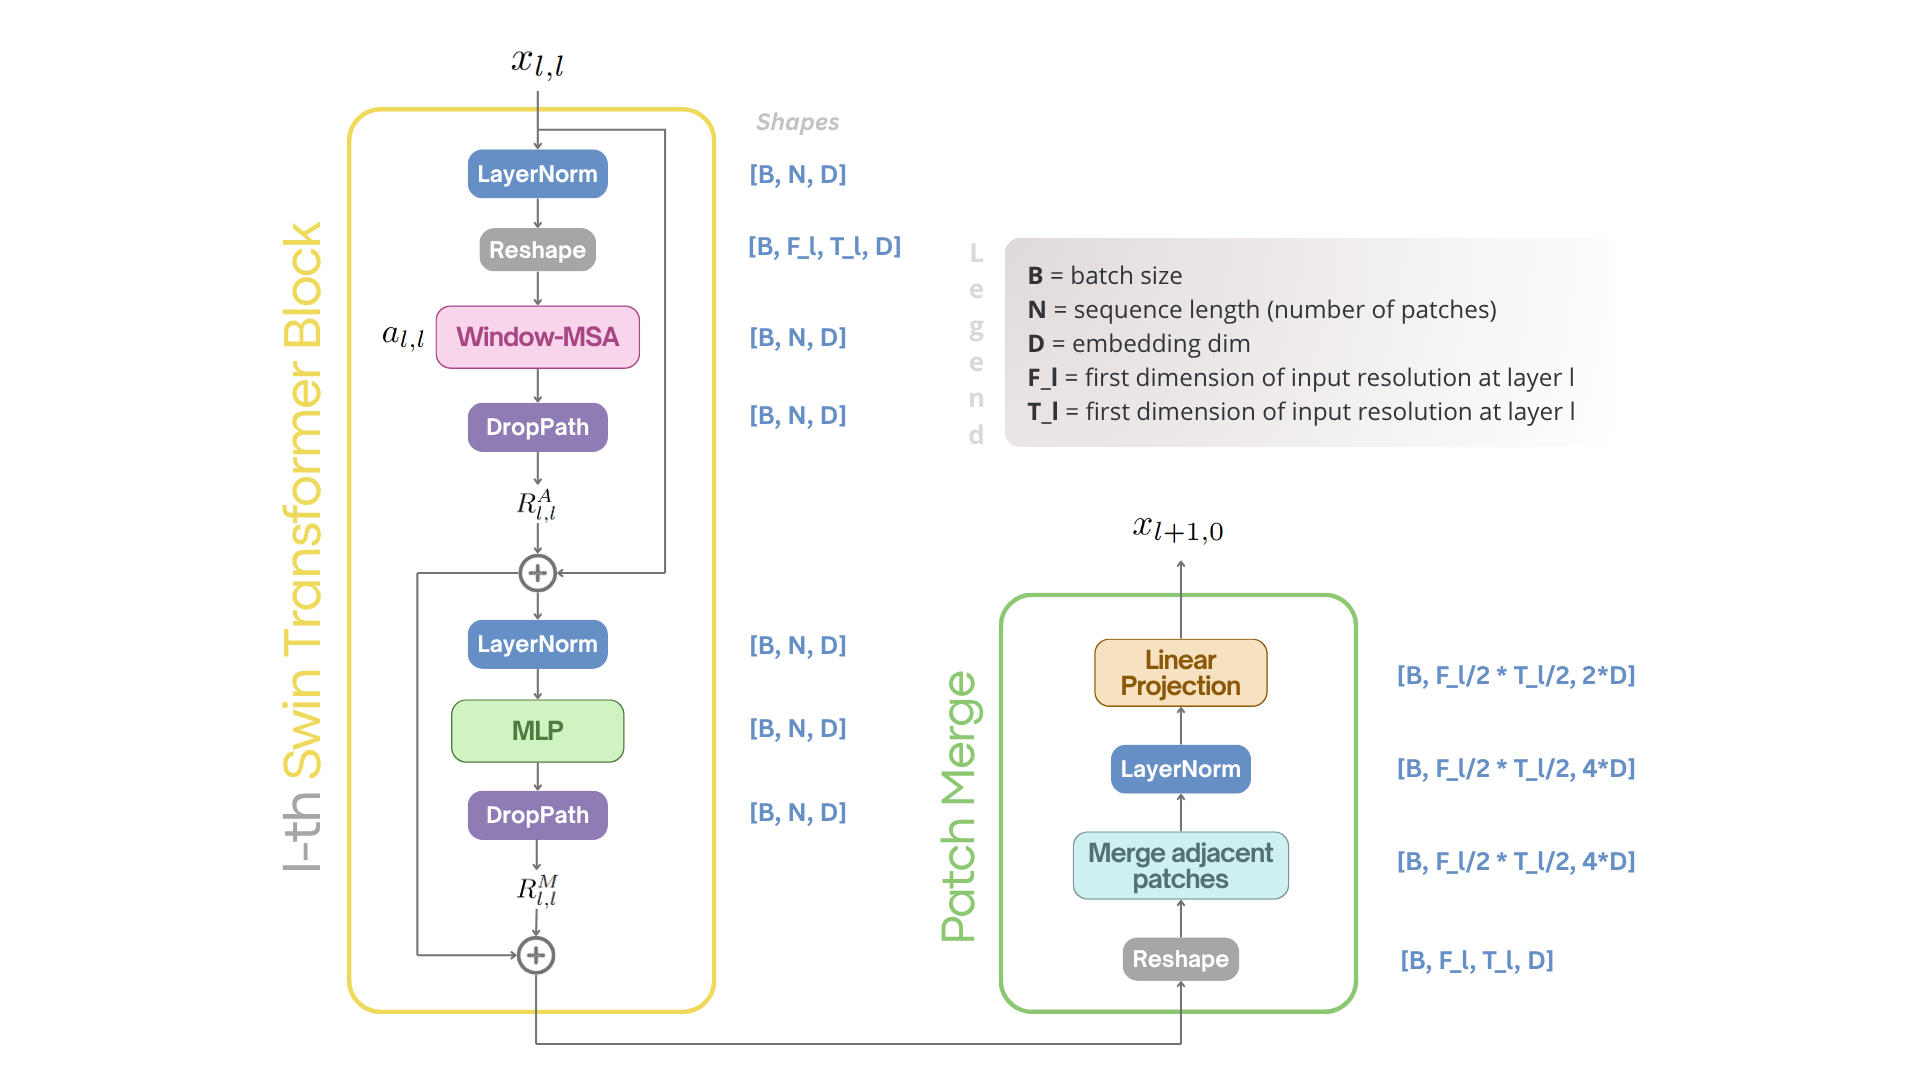

In this notebook, the focus is on analyzing the attention weights produced in each HTSAT transformer layer, by observing each attention head independently.

In particular, attention $a_l = \frac{1}{depth_l} \cdot \sum_{i=0}^{depth_l} a_{i,l}$ is extracted for each layer $l \in [1,L]$, where $depth_l$ is the number of transformer blocks at layer $l$.

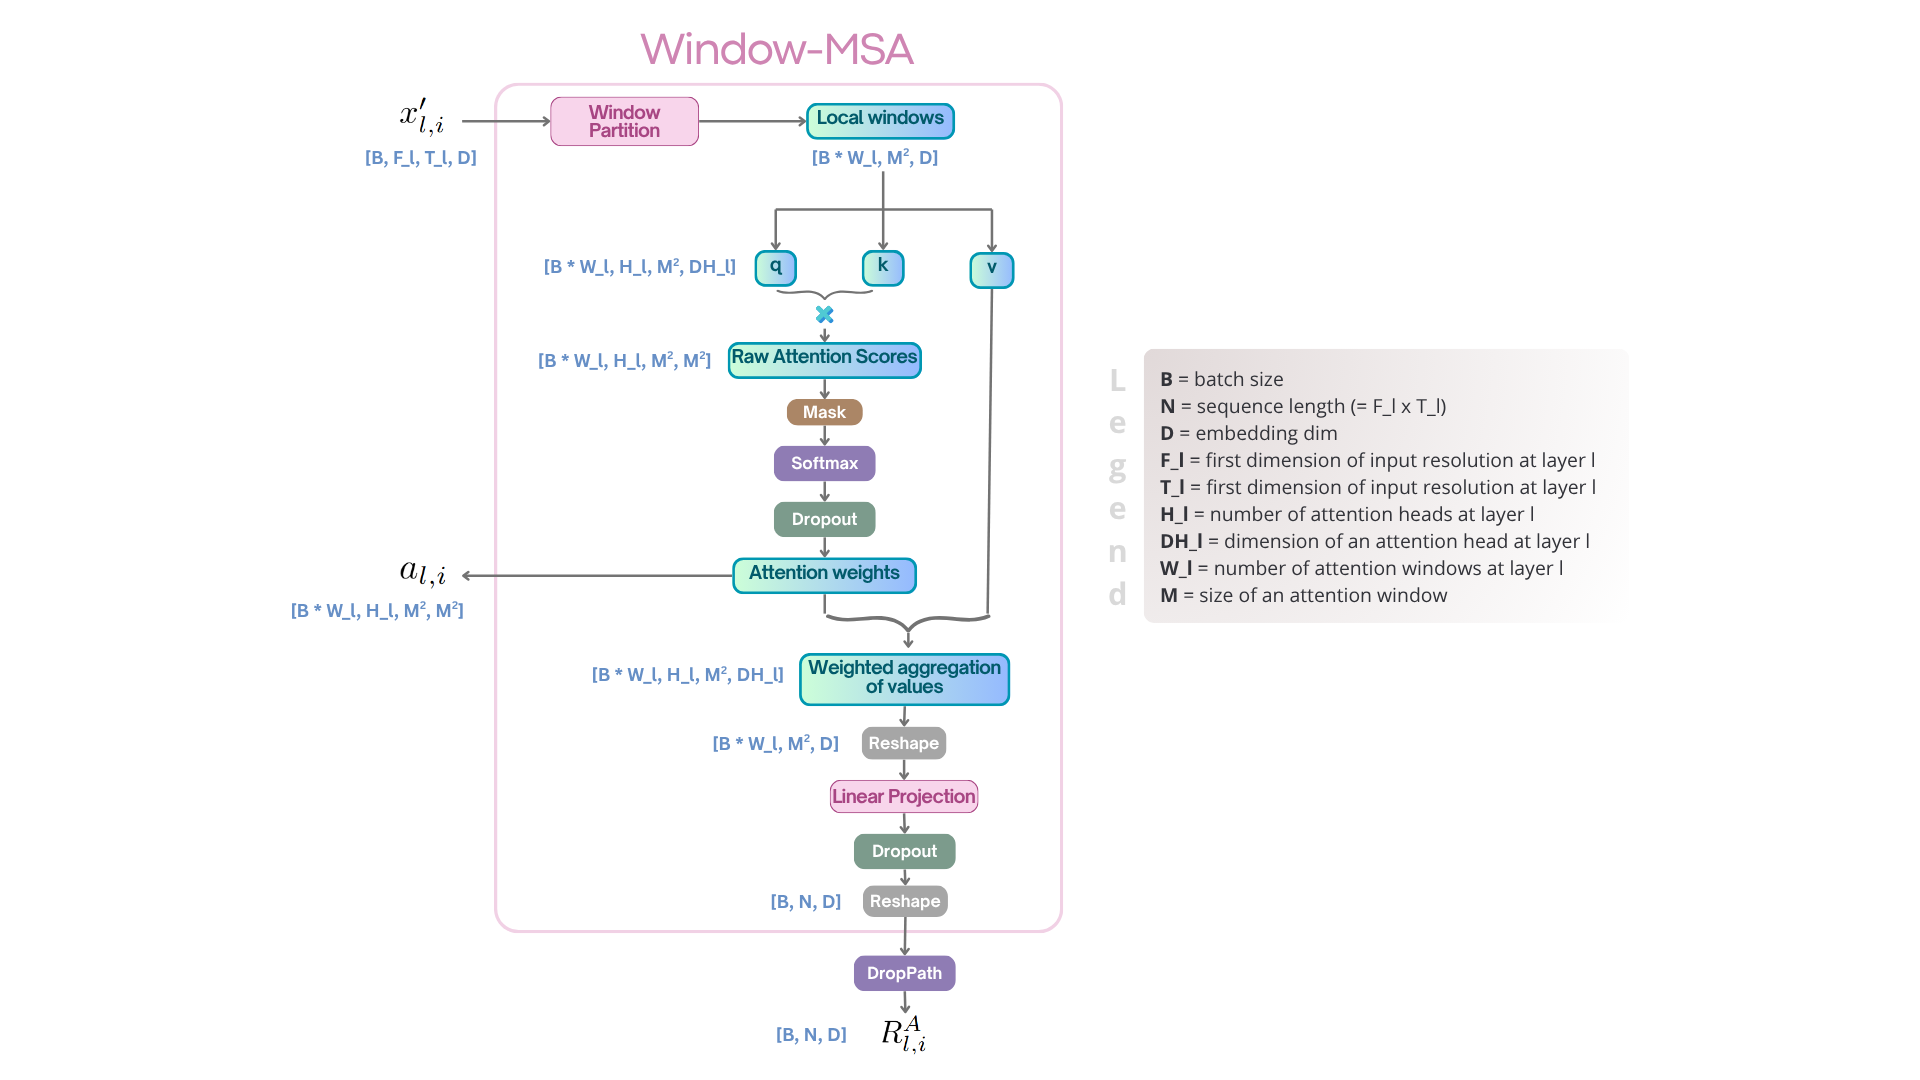

# Analysis of HTSAT attention heads

The goal of this section is to analyze the attention heads in the **HTSAT audio encoder** used in the CLAP architecture to assess whether head specialization occurs in the audio domain and, thus, whether the **ResiDual method** to reweight attention head contributions to the residual stream could be applied effectively.

## Evaluate intrinsic dimensionality via PCA

In [ ]:
#@title Load dataset
DATASET = 'ESC50' #@param ['ESC50', 'UrbanSound8K']
batch_sz = 32 #@param {type:"slider", min:1, max:256, step:1}
audio_dir = os.path.join(TARGET_DIR, DATASETS[DATASET]["audio_dir"])
dataset = AudioDataset(DATASET, get_dataframe(DATASET, cwd=TARGET_DIR), audio_dir)
fold_dataloaders = get_fold_dataloaders(dataset, batch_size=batch_sz)

Download complete.


### Load HTSAT

In [ ]:
clap = CLAP_Module(enable_fusion=False)
clap.load_ckpt() # download default pretrained checkpoint

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
audio_encoder = clap.model.audio_branch

In [ ]:
audio_encoder # HTSAT structure

HTSAT_Swin_Transformer(
  (spectrogram_extractor): Spectrogram(
    (stft): STFT(
      (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(480,), bias=False)
      (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(480,), bias=False)
    )
  )
  (logmel_extractor): LogmelFilterBank()
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(64, 64), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(64, 64), num_heads=4, window_size=8, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-

### Perform PCA

PCA is applied to each attention head and each layer in the HTSAT audio encoder.

In [ ]:
#@title Incremental PCA
def run_PCA(dataloader, num_layers, num_heads, components):

  # simulate audio quantization (loss of precision)
  def quantize_tensor(audio_tensor: torch.Tensor) -> torch.Tensor:
    audio_tensor = torch.clamp(audio_tensor, -1.0, 1.0)
    return (audio_tensor * 32767.0).to(torch.int16).to(torch.float32) / 32767.0

  pca_models = defaultdict(dict)
  for l in range(num_layers):
      for h in range(num_heads[l]):
          pca_models[l][h] = IncrementalPCA(n_components=components)


  for batch in tqdm(dataloader, desc="Applying PCA per layer / per attention head"):

    batch_data = defaultdict(list)
    buffers = defaultdict(list)
    BATCH_THREHSOLD = 30

    x = batch[0] # batch_size x channels x time samples
    audio_data = quantize_tensor(x.squeeze(1)).cpu()

    audio_input = [
          get_audio_features({}, waveform.cpu(), 480000,
              data_truncating='fusion' if clap.enable_fusion else 'rand_trunc',
              data_filling='repeatpad',
              audio_cfg=clap.model_cfg['audio_cfg'],
              require_grad=waveform.requires_grad
          )
          for waveform in audio_data
      ]

    # Extract attention
    with torch.no_grad():
        out_dict = clap.model.get_audio_output_dict(audio_input)
        attn = out_dict["layers_attention"]  # list of Tensors of shape [batch_size * num_windows, num_heads, window_size**2, window_size**2)]

    attn_cpu = [layer.cpu() for layer in attn]

    for l, layer_attn in enumerate(attn_cpu):  # attn[layer]: list of [total_windows, heads, window_size**2, window_size**2]
          for window_attn in layer_attn:     # one window: Tensor [num_heads, window_size**2, window_size**2]
              for h in range(window_attn.shape[0]):
                  head_attn = window_attn[h]  # Tensor  [window_size**2, window_size**2]
                  flat = head_attn.flatten().numpy()  # shape: [window_size**4]
                  batch_data[(l, h)].append(flat)

    for (l, h), samples in batch_data.items():
        buffers[(l,h)].extend(samples)

        if len(buffers[(l,h)]) >= BATCH_THREHSOLD:
          X = np.stack(buffers[(l, h)])
          pca_models[l][h].partial_fit(X) # apply PCA on buffered data
          buffers[(l,h)] = []

    # Clear memory
    del out_dict, attn
    torch.cuda.empty_cache()
    gc.collect()

  return pca_models

In [9]:
NUM_LAYERS = 4 # from https://github.com/LAION-AI/CLAP
NUM_HEADS = [4, 8, 16, 32]
PCA_COMPONENTS = None

In [ ]:
DATASET_NAME = "ESC50" #@param ['ESC50', 'UrbanSound8K']
SAVE_DIR = DRIVE_PATH + "pca_results"
for i, (_, val_load) in enumerate(fold_dataloaders):
   pca_models = run_PCA(val_load, NUM_LAYERS, NUM_HEADS, PCA_COMPONENTS)
   A.save_pca_results_on_file(SAVE_DIR, DATASET_NAME, i, pca_models)

Applying PCA per layer / per attention head: 100%|██████████| 13/13 [39:48<00:00, 183.70s/it]


## Results

In [37]:
#@title Read results from file
DATASET_NAME = "ESC50" #@param ['ESC50', 'UrbanSound8K']
FOLD = 0 #@param
SAVE_DIR = DRIVE_PATH + "pca_results"
res_path = os.path.join(SAVE_DIR, f"{DATASET_NAME}-fold{FOLD}.csv")
res = A.load_pca_csv_results(res_path)

### Visualization

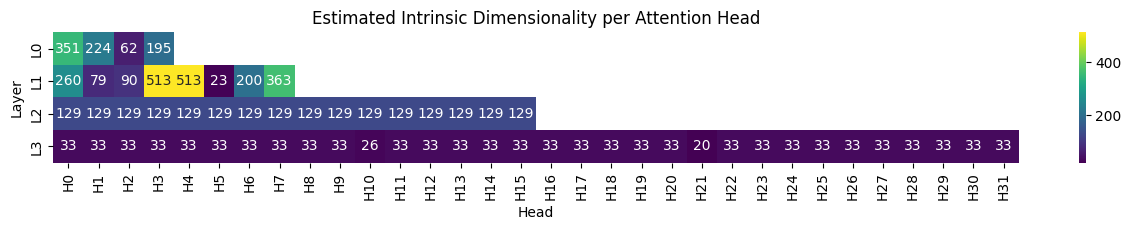

In [38]:
# visualize the estimated intrinsic dim for each layer and attention head
max_heads = max(NUM_HEADS)
intrinsic_dim_data = np.full((NUM_LAYERS, max_heads), np.nan)

for layer in range(NUM_LAYERS):
    for head in range(NUM_HEADS[layer]):
        data = res.get((layer, head))
        if data:
            intrinsic_dim = data["intrinsic_dim"]
            intrinsic_dim_data[layer, head] = intrinsic_dim

xticklabels = [f"H{i}" for i in range(max_heads)]
yticklabels = [f"L{l}" for l in range(NUM_LAYERS)]

plt.figure(figsize=(max_heads * 0.4, NUM_LAYERS * 0.6))
sns.heatmap(intrinsic_dim_data, annot=True, fmt=".0f", cmap="viridis",
            xticklabels=xticklabels, yticklabels=yticklabels,
            mask=np.isnan(intrinsic_dim_data))

plt.title("Estimated Intrinsic Dimensionality per Attention Head")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

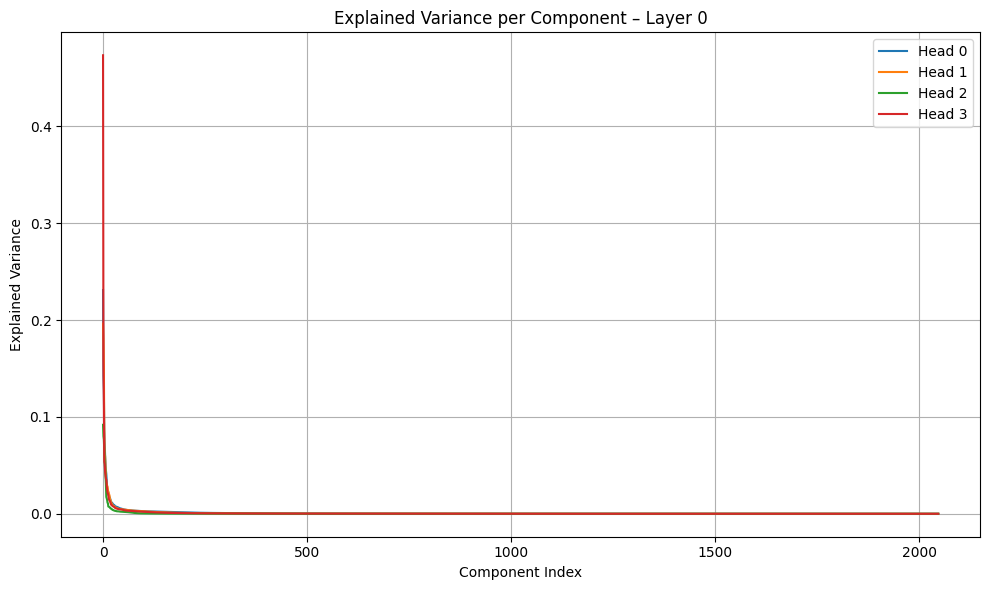

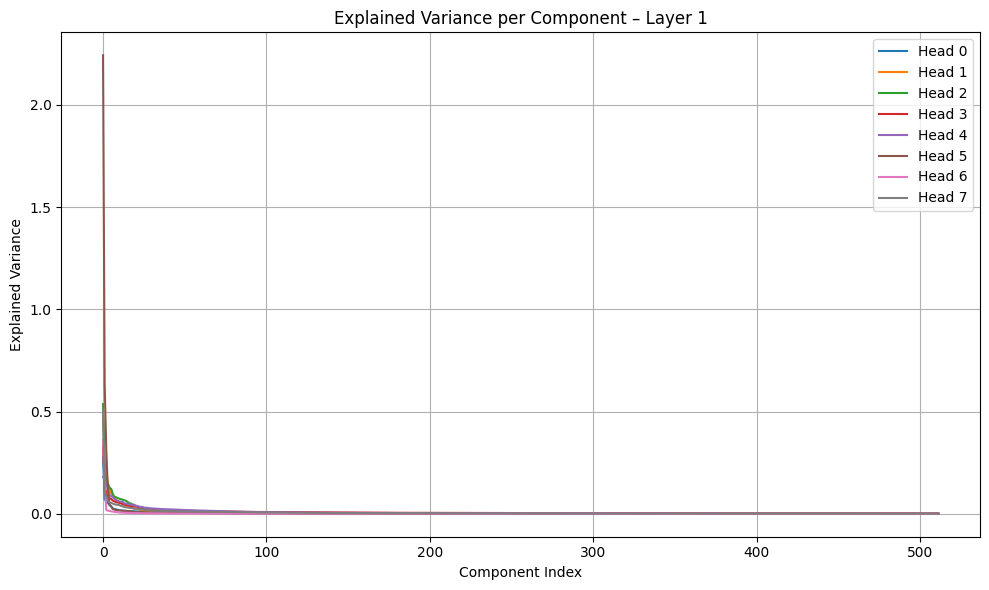

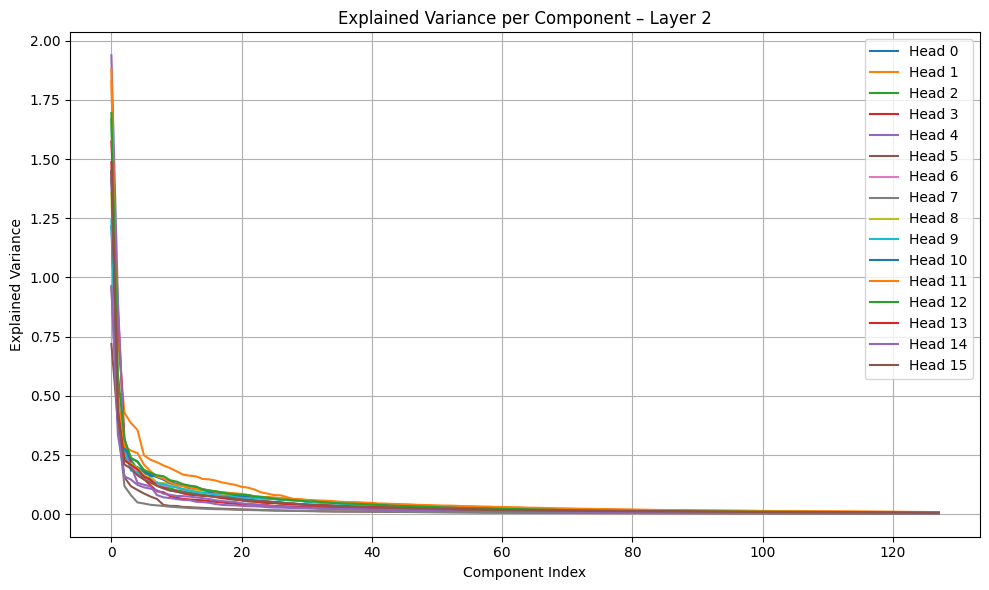

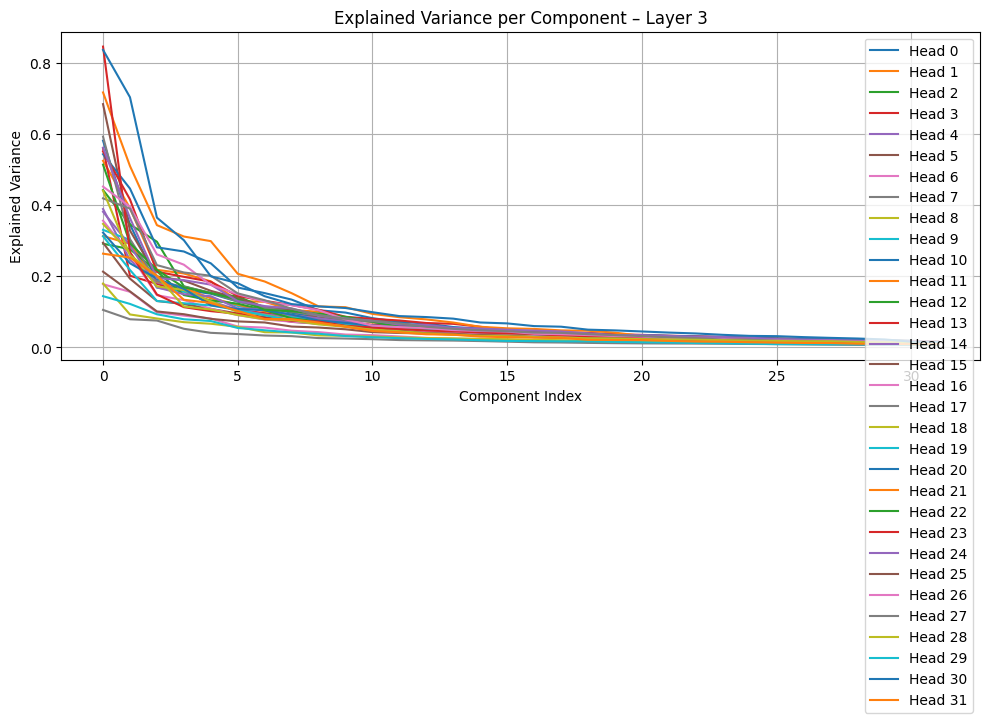

In [39]:
# visualize the plot of the variance explained by each component for different attention heads in each layer
for layer in range(NUM_LAYERS):
  plt.figure(figsize=(10, 6))

  for head in range(NUM_HEADS[layer]):
      data = res.get((layer, head))
      if not data:
          continue
      ev = data["explained_variance"]
      plt.plot(range(len(ev)), ev, label=f"Head {head}")

  plt.title(f"Explained Variance per Component – Layer {layer}")
  plt.xlabel("Component Index")
  plt.ylabel("Explained Variance")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

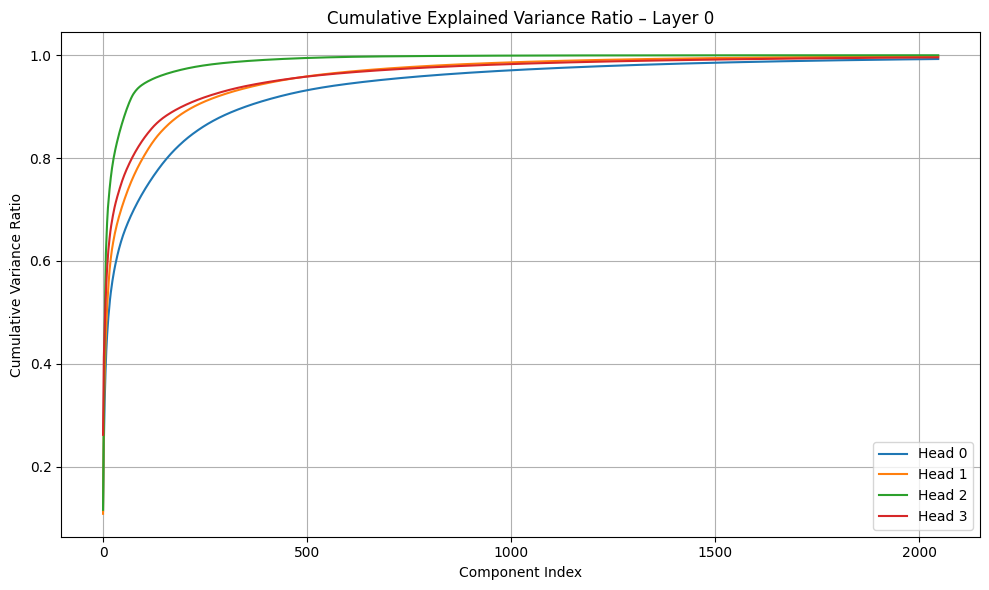

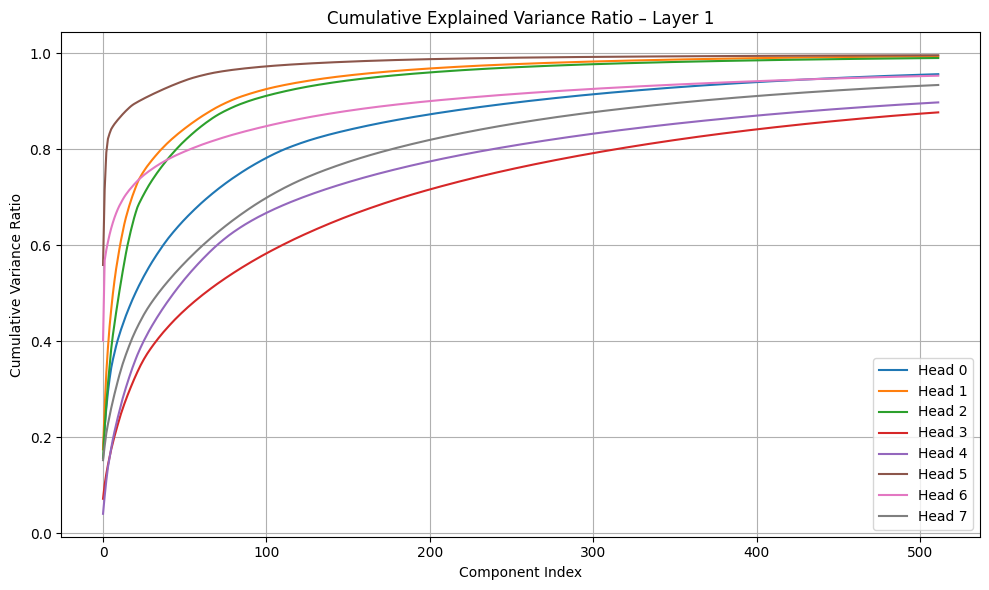

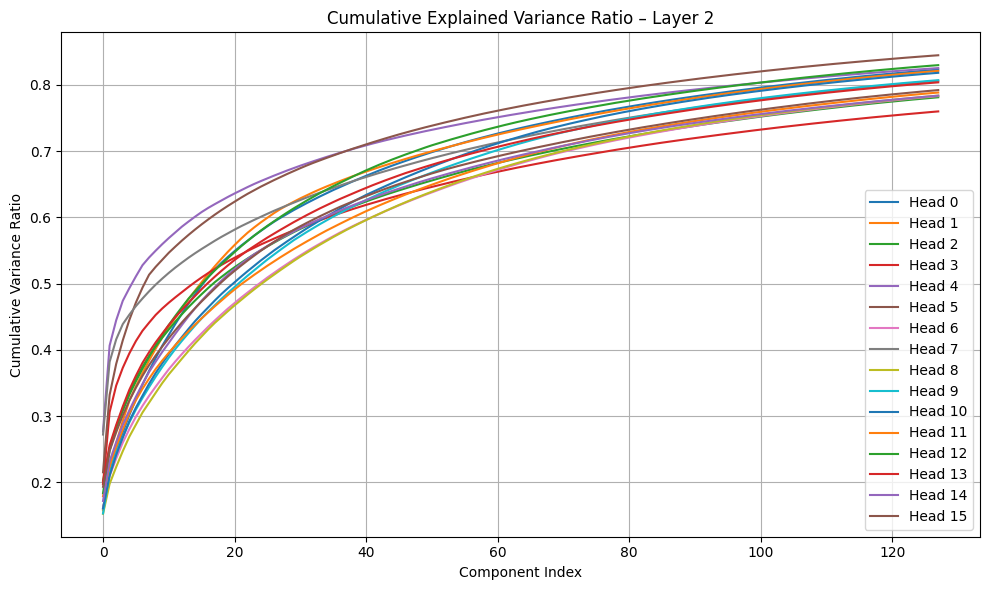

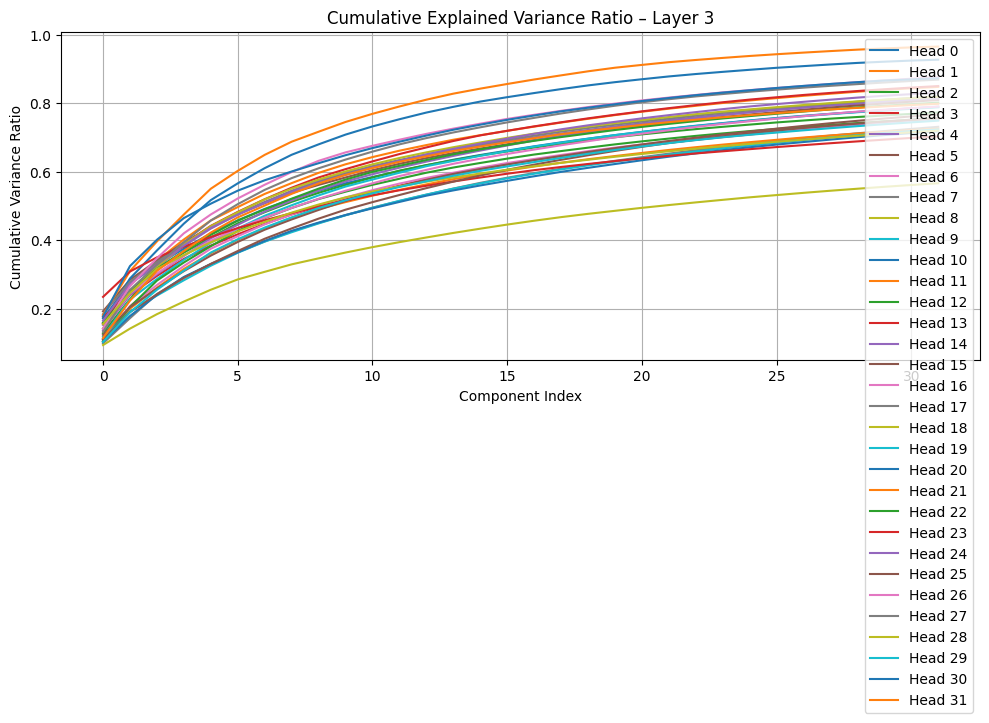

In [40]:
# visualize how many principal components are needed to capture a given percentage of the total variance in the data
for layer in range(NUM_LAYERS):
  plt.figure(figsize=(10, 6))

  for head in range(NUM_HEADS[layer]):
      data = res.get((layer, head))
      if not data:
          continue
      evr = data["explained_variance_ratio"]
      cum_evr = [sum(evr[:i+1]) for i in range(len(evr))]
      plt.plot(range(len(evr)), cum_evr, label=f"Head {head}")

  plt.title(f"Cumulative Explained Variance Ratio – Layer {layer}")
  plt.xlabel("Component Index")
  plt.ylabel("Cumulative Variance Ratio")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

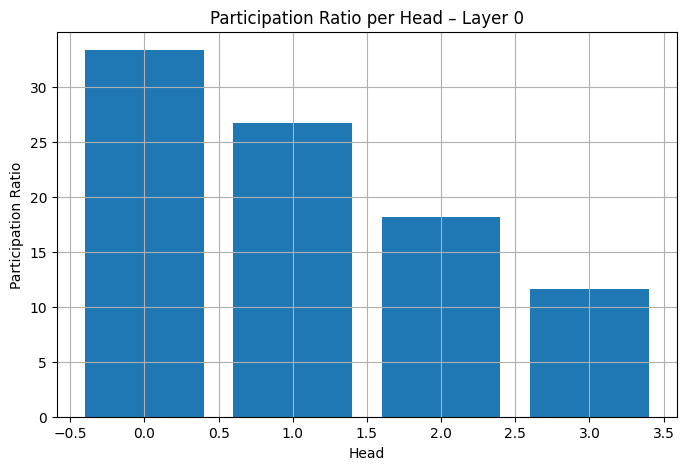

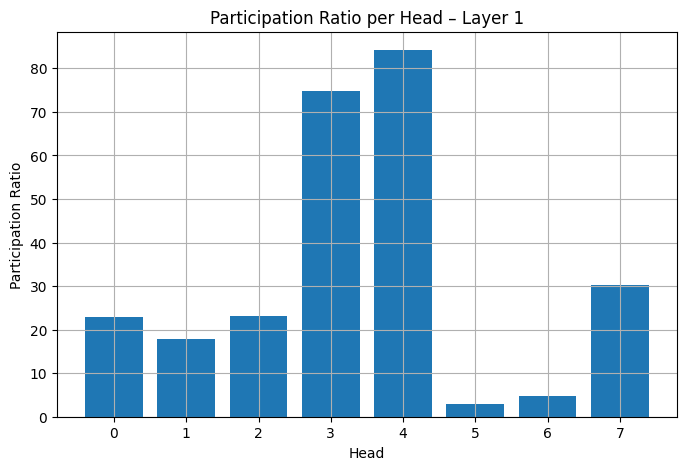

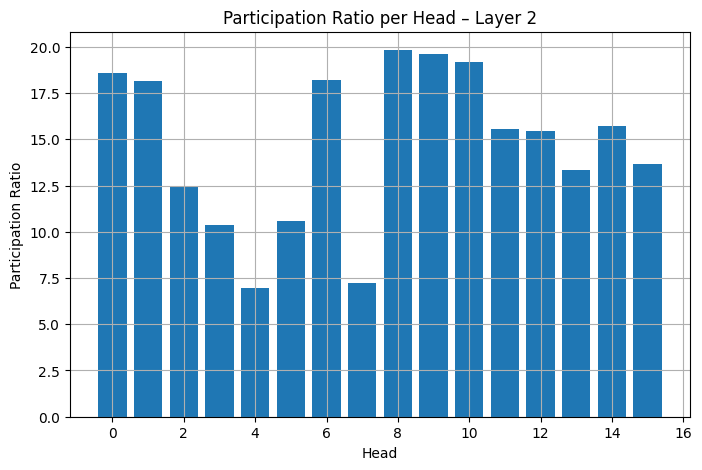

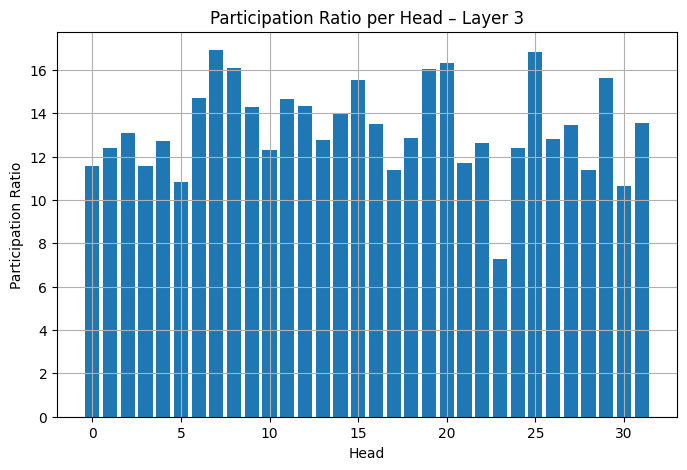

In [41]:
# Visualize participation ratios
for layer in range(NUM_LAYERS):
  heads = []
  prs = []
  for head in range(NUM_HEADS[layer]):
      data = res.get((layer, head))
      if not data:
          continue
      heads.append(head)
      prs.append(data["participation_ratio"])

  plt.figure(figsize=(8, 5))
  plt.bar(heads, prs)
  plt.title(f"Participation Ratio per Head – Layer {layer}")
  plt.xlabel("Head")
  plt.ylabel("Participation Ratio")
  plt.grid(True)
  plt.show()

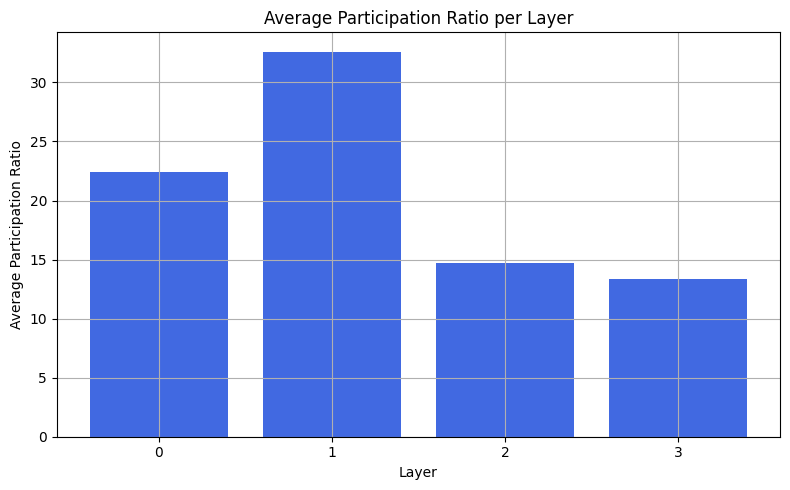

In [42]:
avg_prs = []

for layer in range(NUM_LAYERS):
    layer_prs = []

    for head in range(NUM_HEADS[layer]):
        data = res.get((layer, head))
        if not data:
            continue
        pr = data["participation_ratio"]
        layer_prs.append(pr)

    if layer_prs:  # avoid division by zero
        avg = np.mean(layer_prs)
    else:
        avg = 0
    avg_prs.append(avg)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(NUM_LAYERS), avg_prs, color='royalblue')
plt.title("Average Participation Ratio per Layer")
plt.xlabel("Layer")
plt.ylabel("Average Participation Ratio")
plt.grid(True)
plt.xticks(range(NUM_LAYERS))
plt.tight_layout()
plt.show()